In [1]:
# usual python bookkeeping...
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import Image
import math
from PIL import Image


In [2]:
#ensure all images will be greyscale
plt.gray()

<Figure size 432x288 with 0 Axes>

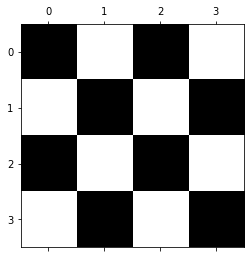

In [3]:
#lets create checkerboard pattern
SIZE =4
img = np.zeros((SIZE, SIZE))
for n in range(0, SIZE):
    for m in range(0, SIZE):
        if (n & 0x1 )^(m & 0x1 ):
            img[m,n] = 255
plt.matshow(img)
                

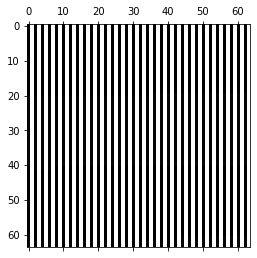

In [4]:
img = plt.imread('Image2.jpeg')
#plt.matshow(img)
img= Image.open('Image2.jpeg').convert('LA')
img = np.asarray(img)
img = np.resize(img,(64,64))
plt.matshow(img)

In [5]:
def canonical(n, M =5, N =10):
    e = np.zeros((M, N))
    e[(n%M), int(n/M)]=1
    return e


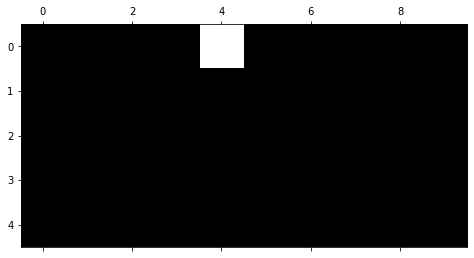

In [6]:
plt.matshow(canonical(20));

Transmitting images

suppose we want to transmit the image over a communication channel. the intuitive way to do so is to send the pixel value one by one, which corresponds to sending the coefficients of the decomposition of image over the canonical basis. So far, nothing complicated to send the image for instance, we will send 64 x 64 = 4096 coefficients in a row

suppose that a communication failure takes place after the first half pixels have been sent. the received data will allow us ti display an approximation of the original image only. if we replace the missing data with zeros, here is what we would see, which is not very pretty.

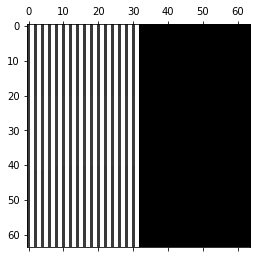

In [7]:
#unrolling of image for transmission
tx_img = np.ravel(img, 'F')

#we lose half the data
tx_img[int(len(tx_img)/2):]=0

# rebuild matrix
rx_img = np.reshape(tx_img,(64, 64), 'F')
plt.matshow(rx_img)

Can we come with a transmission scheme that is more robust in face of channel loss? Interestingly it involves a different, more versatile basis for space of images
describe the Haar basis, a new basis for image soace
project the image in the new basis
transmit the projection coefficients
rebuild the image using the basis vectors

we know a few things: if we choose an orthonormal baiss, the analysis and synthesis formula will be super easy( a simple inner product and a scaar multiplication respectively). the trick is to find a basis that will be robust to the loss of some coefficients.

we will keep things simple, we will remain in the space of a square matrices whose size is the power of two. the code to generate the Haar basis matrices is the following: first we generate a 1D Haar vector and then we obtain the basis matrices by taking the outer product of all possible 1D vectors

In [11]:
def haar1D(n, SIZE):
    #check power of two
    if math.floor(math.log(SIZE)/math.log(2))!=math.log(SIZE)/math.log(2):
        print("Haar defined only for lengths that are powers of two")
        return None
    if n>=SIZE or n<0:
        print("invalide Haar index")
        return None
    #zero basis vector
    if n==0:
        return np.ones(SIZE)
    #express n>1 as 2^p +q with p as large as possible
    # then k= SIZE/2^p is the length of support
    # s = qk is the shift
    p = math.floor(math.log(n)/ math.log(2))
    pp = int(pow(2,p))
    k = SIZE/pp
    s = (n-pp)*k
    
    h = np.zeros(SIZE)
    h[int(s):int(s+k/2)]=1
    h[int(s+k/2):int(s+k)]=-1
    # these are not normalized
    return h

def haar2D(n , SIZE =8):
    # get horizontal and vertical indices
    hr = haar1D(n%SIZE, SIZE)
    hv = haar1D(int(n/SIZE), SIZE)
    # 2D haar basis matrix is separable, so we can
    # just take the column row product
    H = np.outer(hr, hv)
    H = H/math.sqrt(np.sum(H*H))
    return H
                 


first of all, lets look at a few basis matrices; note that the matrices have  positive and negative values, so that the value of zero will be represented as gray:

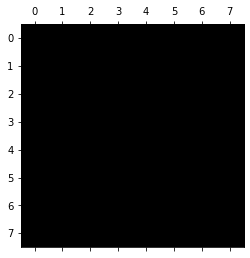

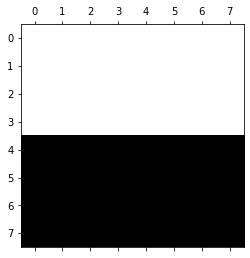

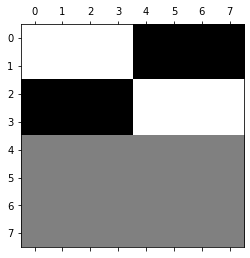

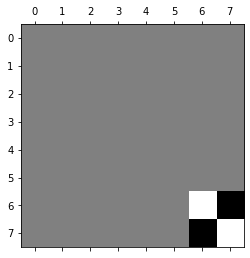

In [13]:
plt.matshow(haar2D(0));
plt.matshow(haar2D(1));
plt.matshow(haar2D(10));
plt.matshow(haar2D(63));


we notice two key properties

each basis matrix has positive and negative values in some symmetric pattern; this means  that basis matrix will implicitly compute the difference between image areas

low index basis matrices take differences between large areas, while high index ones take differences in smaller localized areas of image.

we will immediately verify that Haar matrices are orthogonal


In [16]:
#lets use an 8x8 space; there will be 64 basis vectors
#compute all possible inner product and print the nonzeros
for m in range(0,64):
    for n in range(0,64):
        r = np.sum(haar2D(m,8)*haar2D(n, 8))
        if r!=0:
            print("[%dx%d -> %f]" %(m,n,r), end ="")

[0x0 -> 1.000000][1x1 -> 1.000000][2x2 -> 1.000000][3x3 -> 1.000000][4x4 -> 1.000000][5x5 -> 1.000000][6x6 -> 1.000000][7x7 -> 1.000000][8x8 -> 1.000000][9x9 -> 1.000000][10x10 -> 1.000000][11x11 -> 1.000000][12x12 -> 1.000000][13x13 -> 1.000000][14x14 -> 1.000000][15x15 -> 1.000000][16x16 -> 1.000000][16x17 -> -0.000000][17x16 -> -0.000000][17x17 -> 1.000000][18x18 -> 1.000000][19x19 -> 1.000000][20x20 -> 1.000000][21x21 -> 1.000000][22x22 -> 1.000000][23x23 -> 1.000000][24x24 -> 1.000000][24x25 -> -0.000000][25x24 -> -0.000000][25x25 -> 1.000000][26x26 -> 1.000000][27x27 -> 1.000000][28x28 -> 1.000000][29x29 -> 1.000000][30x30 -> 1.000000][31x31 -> 1.000000][32x32 -> 1.000000][33x33 -> 1.000000][34x34 -> 1.000000][35x35 -> 1.000000][36x36 -> 1.000000][37x37 -> 1.000000][38x38 -> 1.000000][39x39 -> 1.000000][40x40 -> 1.000000][41x41 -> 1.000000][42x42 -> 1.000000][43x43 -> 1.000000][44x44 -> 1.000000][45x45 -> 1.000000][46x46 -> 1.000000][47x47 -> 1.000000][48x48 -> 1.000000][49x49 ->

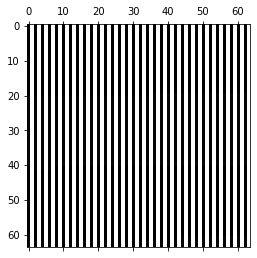

In [17]:
# project the image onto the Haar basis, obtaining a vector of 4096 coefficients
# this is simply the analysis formula for the vector space with an orthogonal basis
tx_img = np.zeros(64*64)
for k in range(0, (64*64)):
    tx_img[k] = np.sum(img * haar2D(k, 64))

# now rebuild the image with the synthesis formula; since the basis is orthonormal
#  we just need to scale the basis matrices by the projection coefficients
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += tx_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

That's quite remarkable, no? We've lost the same amount of information as before but the image is still acceptable. This is because we lost the coefficients associated to the fine details of the image but we retained the "broad strokes" encoded by the first half.

Note that if we lose the first half of the coefficients the result is markedly different:

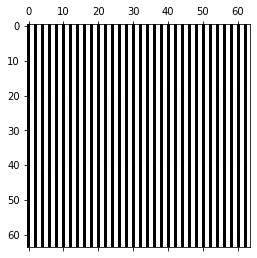

In [18]:
lossy_img = np.copy(tx_img);
lossy_img[0:int(len(tx_img)/2)] = 0

rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += lossy_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

In fact, schemes like this one are used in progressive encoding: send the most important information first and add details if the channel permits it. You may have experienced this while browsing the interned over a slow connection.

All in all, a great application of a change of basis!